In [12]:
from zipfile import ZipFile
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

import matplotlib.pylab as plt
from dmba import printTermDocumentMatrix, classificationSummary, liftChart
# download data required for NLTK
nltk.download('punkt')
nltk.download('wordnet')

# For KMeans
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import seaborn as sns
from pandas.plotting import parallel_coordinates 


[nltk_data] Downloading package punkt to /Users/cgagnon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/cgagnon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Import Data

In [3]:
train=[]
test=[]

with ZipFile('drugLib_raw.zip') as rawData:
        for info in rawData.infolist():
            with rawData.open(info.filename) as f:
                if 'drugLibTest_raw' in info.filename:
                    test = pd.read_csv(f, delimiter="\t")
                else:
                    train = pd.read_csv(f, delimiter="\t")



## 2. Combine and cleanup

In [4]:
drugLib = pd.concat([train, test])
drugLib.commentsReview = drugLib.commentsReview.apply(lambda x: 'None' if len(str(x)) < 6 else x)
drugLib.rating = drugLib.rating.apply(lambda x: 1 if int(x) > 5 else 0)
drugLib

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,0,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,0,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,1,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,0,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,0,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...,...
1031,690,accutane,1,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
1032,1071,proair-hfa,1,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
1033,681,accutane,1,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
1034,2709,divigel,1,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


## 3. Corpus and Labels

In [5]:
corpus = []
labels = []

for s in drugLib.commentsReview:
    corpus.append(s)

for r in drugLib.rating:
    labels.append(r)

Counter(labels)

Counter({0: 1128, 1: 3015})

I currently seely about 3 times the amount of 1 ratings (which meant >0 in the old dataset) to 0 ratings.

## 4. TF-IDF

In [6]:
# Apply CountVectorizer and TfidfTransformer sequentially
count_vect = CountVectorizer()
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
counts = count_vect.fit_transform(corpus)
tfidf = tfidfTransformer.fit_transform(counts)

printTermDocumentMatrix(count_vect, tfidf)

          S1   S2   S3   S4   S5   S6   S7   S8   S9  S10  ...  S4134  S4135  \
00       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
000      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
000mg    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
00am     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
00pm     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
zpak     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zy       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zyban    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zyprexa  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zyrtec   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   

         S4136  S4137  S4138  S4139  S4

## 5.  Preprocess the text of your corpus (tokenization, stemming, and stopwords) and print the matrix shape of your preprocessed text


In [7]:
# Preprocessing (tokenization, stemming, and stopwords)

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopWords = set(ENGLISH_STOP_WORDS)
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if t.isalpha() and t not in self.stopWords]

preprocessor = CountVectorizer(tokenizer=LemmaTokenizer(), encoding='english')
preprocessedText = preprocessor.fit_transform(corpus)

In [8]:
# TF-IDF and latent semantic analysis
tfidfTransformer = TfidfTransformer()
tfidf = tfidfTransformer.fit_transform(preprocessedText)

## 6. Generate the TF-IDF matrix for latent semantic analysis. Using the TruncatedSVD() function, extract 10 and follow the example in the textbook to generate the lsa_tfidf matrix.


In [9]:
# Extract 10 concepts using LSA ()
svd = TruncatedSVD(10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_tfidf = lsa.fit_transform(tfidf)

## 7. Split the lsa_tfidf and label dataset into 60% training and 40% test set and apply logistic regression to predict the test dataset label. How is the accuracy of your model? Also, plot the corresponding gains and lift charts.


In [10]:
# split dataset into 60% training and 40% test set
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, labels, test_size=0.4, random_state=24)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
classificationSummary(ytest, logit_reg.predict(Xtest))

Confusion Matrix (Accuracy 0.7268)

       Prediction
Actual    0    1
     0    0  453
     1    0 1205


## 8. Refer back to the k-means code from Chapter 15 and generate and plot the centroids of 3 clusters using the parallel_coordinates() function. Which component seems to distinguish the clusters better? Also, comment on the within and between cluster distances in your clusters.

In [19]:
len(lsa_tfidf)
len(drugLib.urlDrugName)

4143

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(lsa_tfidf)

# Cluster membership
memb = pd.Series(kmeans.labels_, index=drugLib.urlDrugName)
#for key, item in memb.groupby(memb):
#    print(key, ': ', ', '.join(item.index)) 

In [23]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
pd.set_option('precision', 3)
centroids

,0,1,2,3,4,5,6,7,8,9
0,0.545,0.003,0.004,0.057,0.006,0.005,-0.020,0.017,-0.026,0.024
1,0.511,-0.566,-0.186,-0.217,-0.135,-0.009,-0.126,0.016,-0.071,-0.073
2,0.358,-0.267,-0.063,0.005,-0.126,-0.069,0.568,-0.186,0.093,0.023


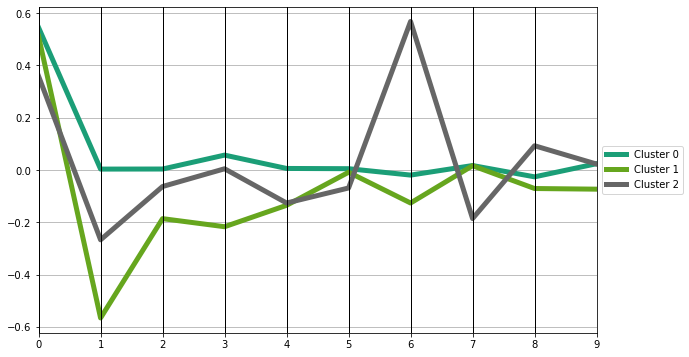

In [24]:
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
plt.figure(figsize=(10,6))
parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 

## 9. Optional (Extra credit). Try to apply the RNN model for sentiment analysis about comment reviews (e.g., use the corpus as your text, and the label vector as your sentiment column—1 means positive and 0 means negative). Change your hyperparameters as you see fit and run 10 epochs. How is the accuracy of your model?

In [28]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras_visualizer import visualizer 

# Neural network
model = Sequential()

model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #sigmoid since this is binary classifiction
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


In [29]:
#compile the model
model.compile(Adam(lr = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy']) #lr = learning rate

In [30]:
# training (60%) and validation (40%)
train_X, valid_X, train_y, valid_y = train_test_split(corpus, labels, test_size=0.4, random_state=1)

#train the model
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data = (valid_X,valid_y))


Epoch 1/10


UnimplementedError:  Cast string to float is not supported
	 [[node sequential_1/Cast (defined at <ipython-input-30-ec589e82222a>:5) ]] [Op:__inference_train_function_899]

Function call stack:
train_function
